<a href="https://colab.research.google.com/github/PETEROA/Model-Compression-Transfer_Learning/blob/main/Data_free.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exploring data free knowledge distillation for model compression.. trying to transfer knowledge from larger teacher to student model using synthetic data and multi-component loss optimisation.

In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Optional
import random
from abc import ABC, abstractmethod

In [102]:
#set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

this class represents an NN designed to capture patterns and relationships in data. Teacher network serves as the expert that has already learned from extensive training data and will transfer its knowledge to smaller models without requiring access to the original training dataset.

In [103]:
class TeacherNetwork(nn.Module):
  # Pre-trained teacher network (Larger capacity)
  def __init__(self, input_size: int = 784, num_classes: int = 10):
    super(TeacherNetwork, self).__init__()
    self.feature_extractor = nn.Sequential(
        nn.Linear(input_size, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 128),
        nn.ReLU()
    )
    self.classifier = nn.Linear(128, num_classes)

  def forward(self, x):
    features = self.feature_extractor(x)
    logits = self.classifier(features)
    return logits, features

class represents a lightweigt model optimized for deployment in resource constrained env.. student network specifically designed to acheive max knowledge retention while using significantly fewer params than the teacher.

In [104]:
class StudentNetwork(nn.Module):
  # smaller student network to be trained

  def __init__(self, input_size: int = 784, num_classes: int = 10):
    super(StudentNetwork, self).__init__()
    self.feature_extractor = nn.Sequential(
        nn.Linear(input_size, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU()
    )
    self.classifier = nn.Linear(64, num_classes)

  def forward(self, x):
    features = self.feature_extractor(x)
    logits = self.classifier(features)
    return logits, features

abstract class establishes a standardized framework for implementing various synthetic data generation approaches.. ensures consistency accross diff generation strategies while allowing for algorithmic diversity in how synthetic training samples are created.

In [105]:
class DataGenerator(ABC):
  #Abstract base class for synthetic data generation

  @abstractmethod
  def generate_batch(self, batch_size: int, device: torch.device) -> torch.Tensor:
    pass

class provides a simple approach to data free generation by creating random samples from normal distributions.

In [106]:
class GaussianDataGenerator(DataGenerator):
  # generates synthetic data from Gaussian distribution
  def __init__(self, input_size: int = 784):
    self.input_size = input_size

  def generate_batch(self, batch_size: int, device: torch.device) -> torch.Tensor:
    return torch.randn(batch_size, self.input_size, device=device)

class implements the infrastructure for adversarial synthetic data creation where data generation is optimized through adversarial training principles. the generator learns to create samples that maximise the info content extracted from the teacher network.

In [107]:
class AdvesarialDataGenerator(DataGenerator):
  # generates synthetic data from adversarial approach

  def __init__(self, input_size: int = 784, lr: float = 0.1):
    self.input_size = input_size
    self.lr = lr

  def generate_batch(self, batch_size: int, device: torch.device) -> torch.Tensor:
    # start with random noise
    data = torch.randn(batch_size, self.input_size, device=device, requires_grad=True)
    return data

class implements a data generation strategy that creates samples specifically designed to elicit diverse and informative responses from the teacher network... by maximising prediction entropy, it ensures that generated samples cover a wide range of the teacher's learned decision boundaries.

In [108]:
class ActivationBasedGenerator(DataGenerator):
  # Generates data to maximise specific activation patterns

  def __init__(self, input_size: int = 784, teacher_model: nn.Module = None):
    self.input_size = input_size
    self.teacher_model = teacher_model

  def generate_batch(self, batch_size: int, device: torch.device) -> torch.Tensor:
    # generate data that maximises activation diversity
    data = torch.randn(batch_size, self.input_size, device=device)

    if self.teacher_model is not None:
      # Optimize data to maximise entropy of teacher predictions
      data.requires_grad_(True)
      optimizer = optim.Adam([data], lr=0.01)

      for _ in range(10): # few optimization steps
        optimizer.zero_grad()
        with torch.enable_grad():
          logits, _ = self.teacher_model(data)
          # Maximise entropy (uncertainty)
          probs = F.softmax(logits, dim=1)
          entropy = -torch.sum(probs * torch.log(probs + 1e-8), dim=1)
          loss = -entropy.mean() #Negative to maximise
          loss.backward()
          optimizer.step()

      data = data.detach()

    return data


class coordinates the process of transferring knowledge from teacher to student networks using multiple complementary loss components.. each component captures diff aspects of the teacher's knowledge ensuring comprehensive transfer of both prediction capabilities and internal representations... combines multiple loss functions with tuned weights to balance diff aspects of knowledge transfer..

In [109]:
class DataFreeDistillationLoss:
  # Comprehensive loss function for data-free distillation

  def __init__(self, temperature: float = 4.0, alpha: float = 0.7, beta: float = 0.3):
    self.temperature = temperature
    self.alpha = alpha # Weight for distillation loss
    self.beta = beta # Weight for feature matching loss

  def distillation_loss(self, student_logits: torch.Tensor, teacher_logits: torch.Tensor) -> torch.Tensor:
    # Knowledge distillation loss for using soft targets
    student_soft = F.log_softmax(student_logits / self.temperature, dim=1)
    teacher_soft = F.softmax(teacher_logits / self.temperature, dim=1)
    return F.kl_div(student_soft, teacher_soft, reduction='batchmean')

  def feature_matching_loss(self, student_features: torch.Tensor, teacher_features: torch.Tensor) -> torch.Tensor:
    # Feature matching loss btw intermediate representations
    # Normalize features
    student_norm = F.normalize(student_features, p=2, dim=1)
    teacher_norm = F.normalize(teacher_features, p=2, dim=1)

    # Mean squared error btw normalized features
    return F.mse_loss(student_norm, teacher_norm)

  def attention_transfer_loss(self, student_features: torch.Tensor, teacher_features: torch.Tensor) -> torch.Tensor:
    # Attention transfer loss based on feature maps
    def attention_map(features):
      # Compute attention as spatial average
      return torch.mean(features.pow(2), dim=1, keepdim=True)

    student_attention = attention_map(student_features)
    teacher_attention = attention_map(teacher_features)

    return F.mse_loss(student_attention, teacher_attention)

  def compute_total_loss(self, student_logits: torch.Tensor, teacher_logits: torch.Tensor,student_features: torch.Tensor, teacher_features: torch.Tensor) -> Dict[str, torch.Tensor]:
    # Compute total loss combining multiple components
    distill_loss = self.distillation_loss(student_logits, teacher_logits)
    feature_loss = self.feature_matching_loss(student_features, teacher_features)
    attention_loss = self.attention_transfer_loss(student_features, teacher_features)

    total_loss = (self.alpha * distill_loss + self.beta * feature_loss + 0.1 * attention_loss)

    return {
        'total_loss': total_loss,
        'distillation_loss': distill_loss,
        'feature_loss': feature_loss,
        'attention_loss': attention_loss
    }


class serves as the central controller of the distillation pipeline, coordinating syn data gen, knowledge transfer loss computation, and student network optimization... manages interaction btw all system components while tracking training progress and performance metrics.

Using device: cpu
=== Model Architecture Comparison ===
Teacher Model Parameters: 567434
Student Model Parameters: 109386
Compression Ratio: 5.19x

===Preparing Teacher Model ===
Training teacher model...
Epoch 0, Loss: 0.4873
Epoch 10, Loss: 0.0000
Epoch 20, Loss: 0.0000
Epoch 30, Loss: 0.0000
Epoch 40, Loss: 0.0000
Teacher training completed

Starting d-free distillation training for 500 steps..
Step    0 | Total Loss: 2.9647 | Distill: 0.1015 | Feature: 0.0152
Step  100 | Total Loss: 0.1752 | Distill: 0.0670 | Feature: 0.0008
Step  200 | Total Loss: 0.1769 | Distill: 0.0652 | Feature: 0.0008
Step  300 | Total Loss: 0.1968 | Distill: 0.0669 | Feature: 0.0008
Step  400 | Total Loss: 0.1785 | Distill: 0.0667 | Feature: 0.0008
Training complete!


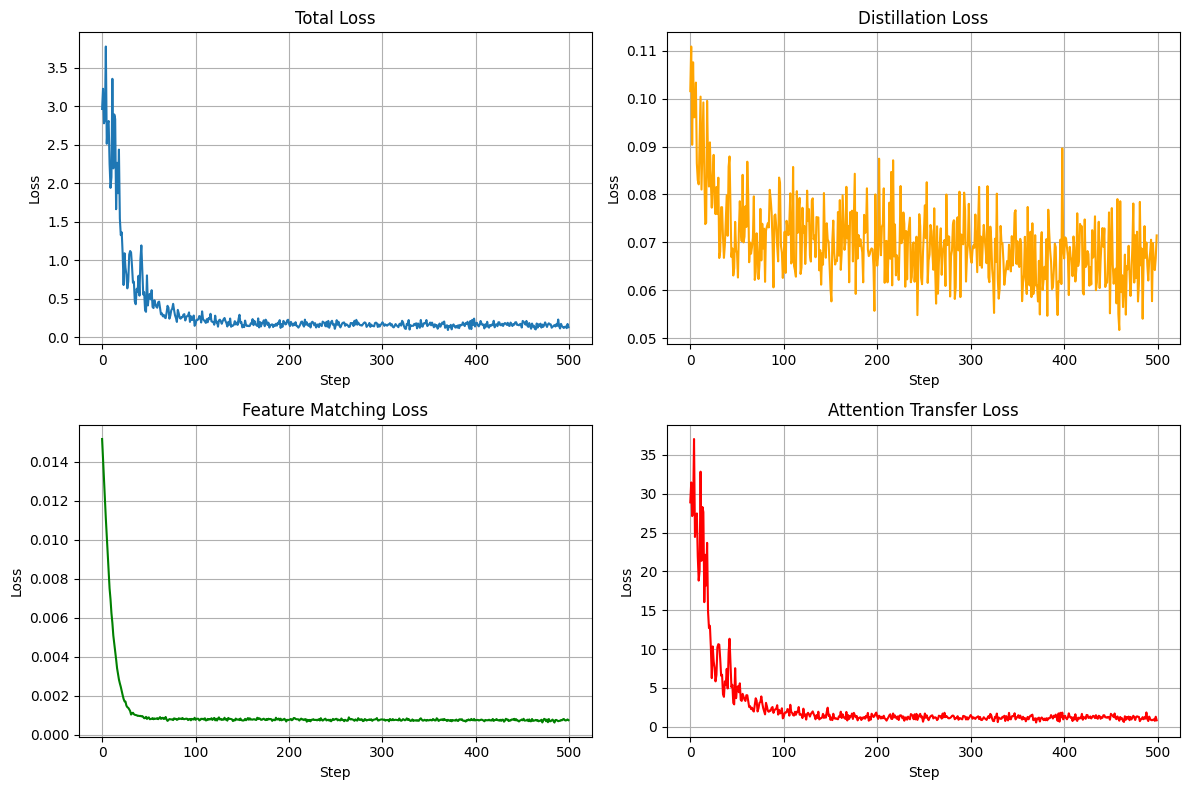


=== Synthetic Data Diversity ===
Mean Entropy of Teacher Predictions: 1.3515
Variance of Teacher Predictions: 0.0247


In [113]:
class DataFreeDistiller:
  # Main class for data free knowledge distillation
  def __init__(self, student: nn.Module, teacher: nn.Module, data_generator: DataGenerator, device: torch.device):
    self.teacher = teacher
    self.student = student
    self.data_generator = data_generator
    self.device = device
    self.loss_fn = DataFreeDistillationLoss()

    # Initialize projection layers if feature dimensions do not match
    dummy_data = torch.randn(1, self.student.feature_extractor[0].in_features).to(device) # Use input size for dummy data
    with torch.no_grad():
        student_dummy_features = self.student.feature_extractor(dummy_data)
        teacher_dummy_features = self.teacher.feature_extractor(dummy_data)


    student_feature_dim = student_dummy_features.size(1)
    teacher_feature_dim = teacher_dummy_features.size(1)

    if student_feature_dim != teacher_feature_dim:
        self.feature_projection = nn.Linear(student_feature_dim, teacher_feature_dim).to(device)
        self.attention_projection = nn.Linear(student_feature_dim, teacher_feature_dim).to(device)
        # Add projection layer parameters to student optimizer
        self.optimizer = optim.Adam(list(self.student.parameters()) + list(self.feature_projection.parameters()) + list(self.attention_projection.parameters()), lr=0.001)
    else:
        self.feature_projection = None
        self.attention_projection = None
        self.optimizer = optim.Adam(self.student.parameters(), lr=0.001)


    # Move models to device
    if self.teacher is not None:
        self.teacher.to(device)
    if self.student is not None:
        self.student.to(device)


    # set teacher to eval mode
    if self.teacher is not None:
        self.teacher.eval()

    # Training history
    self.history = {
        'total_loss': [],
        'distillation_loss': [],
        'feature_loss': [],
        'attention_loss': []
    }

  def train_step(self, batch_size: int = 32) -> Dict[str, float]:
    # Single training step
    if self.student is None or self.teacher is None or self.data_generator is None:
        raise ValueError("Student, teacher, and data generator must be initialized before training.")

    self.student.float()
    if self.optimizer is not None:
        self.optimizer.zero_grad()

    # Generate synthetic data
    synthetic_data = self.data_generator.generate_batch(batch_size, self.device)

    # Get teacher predictions
    with torch.no_grad():
      teacher_logits, teacher_features = self.teacher(synthetic_data)

    # Get student predictions
    student_logits, student_features = self.student(synthetic_data)

    # Apply projection if needed
    if self.feature_projection is not None:
        student_features_projected = self.feature_projection(student_features)
    else:
        student_features_projected = student_features

    if self.attention_projection is not None:
        student_features_attention_projected = self.attention_projection(student_features)
    else:
        student_features_attention_projected = student_features


    # Compute losses
    losses = self.loss_fn.compute_total_loss(student_logits, teacher_logits, student_features_projected, teacher_features)
    # Recompute attention loss with projected features
    attention_loss = self.loss_fn.attention_transfer_loss(student_features_attention_projected, teacher_features)
    losses['total_loss'] = losses['total_loss'] - 0.1 * losses['attention_loss'] + 0.1 * attention_loss # Update total loss with new attention loss
    losses['attention_loss'] = attention_loss


    # Backpropagate and update
    losses['total_loss'].backward()
    if self.optimizer is not None:
        self.optimizer.step()

    #Return loss values as floats
    return {k: v.item() if torch.is_tensor(v) else v for k, v in losses.items()}


  def train(self, num_steps: int = 1000, batch_size: int = 32, log_interval: int = 100) -> Dict[str, List[float]]:
    # Train the student model using data free distillation
    print(f"Starting d-free distillation training for {num_steps} steps..")

    for step in range(num_steps):
      losses = self.train_step(batch_size)

      # Log losses
      for key, value in losses.items():
        self.history[key].append(value)

      if step % 100 == 0:
        print(f"Step {step:4d} | Total Loss: {losses['total_loss']:.4f} | "
              f"Distill: {losses['distillation_loss']:.4f} | "
              f"Feature: {losses['feature_loss']:.4f}")

    print("Training complete!")
    return self.history

  def evaluate_diversity(self, num_batches: int = 10, batch_size: int = 32) -> Dict[str, float]:
    #eval diversity of generated synthetic data
    all_predictions = []

    self.teacher.eval()
    with torch.no_grad():
      for _ in range(num_batches):
        synthetic_data = self.data_generator.generate_batch(batch_size, self.device)
        predictions_tuple = self.teacher(synthetic_data) # Assuming teacher returns both logits and features
        predictions = F.softmax(predictions_tuple[0], dim=1) # Apply softmax to logits
        all_predictions.append(predictions)


    all_predictions = torch.cat(all_predictions, dim=0)

    # compute diversity metrics
    mean_entropy = -torch.sum(all_predictions * torch.log(all_predictions + 1e-8), dim=1).mean()
    prediction_variance = torch.var(all_predictions, dim=0).mean()

    return {
        'mean_entropy': mean_entropy.item(),
        'prediction_variance': prediction_variance.item()
    }

  @staticmethod
  def create_synthetic_teacher_data(num_samples: int = 1000, input_size: int = 784, num_classes: int = 10) -> Tuple[torch.Tensor, torch.Tensor]:
    # Create synthetic dataset to train the teacher model
    # Generate diverse synthetic patterns
    data = []
    labels = []

    for class_idx in range(num_classes):
      class_samples = num_samples // num_classes

      # Create class specific patterns
      base_pattern = torch.randn(input_size) * 0.5

      for _ in range(class_samples):
        # Add noise and variations
        sample = base_pattern + torch.randn(input_size) * 0.3
        data.append(sample)
        labels.append(class_idx)

    return torch.stack(data), torch.tensor(labels)

  @staticmethod
  def train_teacher_model(teacher: nn.Module, train_data: torch.Tensor, train_labels: torch.Tensor, device: torch.device, epochs: int = 50) -> nn.Module:
    # Train the teacher model
    teacher.to(device)
    teacher.train()

    dataset = TensorDataset(train_data, train_labels)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(teacher.parameters(), lr=0.001)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    print("Training teacher model...")
    for epoch in range(epochs):
      total_loss = 0
      for batch_data, batch_labels in dataloader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        logits, _ = teacher(batch_data) # Assuming teacher returns both logits and features
        loss = criterion(logits, batch_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

      if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss / len(dataloader):.4f}")

    print("Teacher training completed")
    return teacher

  def visualize_training_progress(self, history: Dict[str, List[float]]):
    # Visualize training progress
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Total loss
    axs[0, 0].plot(history['total_loss'])
    axs[0, 0].set_title('Total Loss')
    axs[0, 0].set_xlabel('Step')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].grid(True)

    #Distillation loss
    axs[0, 1].plot(history['distillation_loss'], color='orange')
    axs[0, 1].set_title('Distillation Loss')
    axs[0, 1].set_xlabel('Step')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].grid(True)

    #Feature loss
    axs[1, 0].plot(history['feature_loss'], color='green')
    axs[1, 0].set_title('Feature Matching Loss')
    axs[1, 0].set_xlabel('Step')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].grid(True)

    #Attention Loss
    axs[1, 1].plot(history['attention_loss'], color='red')
    axs[1, 1].set_title('Attention Transfer Loss')
    axs[1, 1].set_xlabel('Step')
    axs[1, 1].set_ylabel('Loss')
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

  @staticmethod
  def compare_model_sizes():
  # compare the sizes of teacher and student models
    teacher = TeacherNetwork()
    student = StudentNetwork()

    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())

    print(f"Teacher Model Parameters: {teacher_params:d}")
    print(f"Student Model Parameters: {student_params:d}")
    print(f"Compression Ratio: {teacher_params / student_params:.2f}x")

    return teacher_params, student_params

def main():
  # Main Function to demo d free distillation
  device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
  print(f"Using device: {device}")

  # Compare model arch
  print("=== Model Architecture Comparison ===")
  DataFreeDistiller.compare_model_sizes()
  print()

  # Create models
  teacher = TeacherNetwork()
  student = StudentNetwork()

  # Create synthetic teacher data
  print("===Preparing Teacher Model ===")
  train_data, train_labels = DataFreeDistiller.create_synthetic_teacher_data(num_samples=2000)

  # train teacher model
  teacher = DataFreeDistiller.train_teacher_model(teacher, train_data, train_labels, device)
  print()

  # Create data generator (using Gaussian for simplicity as per previous fix attempt)
  data_generator = GaussianDataGenerator()

  # Move models to device after training teacher
  teacher.to(device)
  student.to(device)


  # Initialize and train the distiller
  distiller = DataFreeDistiller(student, teacher, data_generator, device)
  training_history = distiller.train(num_steps=500, batch_size=64)

  # Visualize training progress
  distiller.visualize_training_progress(training_history)

  # Evaluate data diversity
  diversity_metrics = distiller.evaluate_diversity()
  print("\n=== Synthetic Data Diversity ===")
  print(f"Mean Entropy of Teacher Predictions: {diversity_metrics['mean_entropy']:.4f}")
  print(f"Variance of Teacher Predictions: {diversity_metrics['prediction_variance']:.4f}")

if __name__ == "__main__":
  main()